In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

import os
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime

# Verify GPU is detected

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Force TF to only allocate memory as needed on the GPU, otherwise TF attempts to allocate all the memory incase it needs it.
TF using all the memory leads to the "Failed to get convolution algorithm. This is probably because cuDNN failed to initialize," error.
Note that if RTX Voice (or other GPU memory heavy application) isn't running then this isn't needed.

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7168)])
    except RuntimeError as e:
        print(e)

# Training parameters

In [5]:
BATCH_SIZE = 8
EPOCHS = 64

# Image size in pixels.
IMG_HEIGHT = 400
IMG_WIDTH = 400

# Number of images in the training set.
N_TRAIN = 481

# Number of image classes / categories.
CLASS_COUNT = 9

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

# Extra note added to the details file.
EXTRA_NOTES = ""

# Load Data

In [6]:
# Directories of data, each catergory / class of data is in a seperate folder.
# TRAINING_DIR = "training_data/training"
# VALIDATION_DIR = "training_data/validation"
TRAINING_DIR = "reduced_training_data/training"
VALIDATION_DIR = "reduced_training_data/validation"

In [7]:
# Rescale here refers to scaling the pixel values from a range of [0, 255] to a range of [0, 1].
train_image_generator = ImageDataGenerator(rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen_batches = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=TRAINING_DIR,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode="grayscale",
                                                           class_mode='categorical',
                                                           )

Found 481 images belonging to 9 classes.


In [9]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=VALIDATION_DIR,
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="grayscale",
                                                              class_mode='categorical')

Found 117 images belonging to 9 classes.


# Model Layers

In [10]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(CLASS_COUNT, activation='softmax')
])



# Optimizer

In [11]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
#     return tf.keras.optimizers.Adam(lr_schedule)
    return tf.keras.optimizers.Adam()

# Compile Model

In [12]:
model.compile(optimizer=get_optimizer(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Tensorboard Logging + Model Summary 

In [13]:
log_dir = "logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 147456)            0

# Setup Checkpointing the Model

In [15]:
def get_details():
    DETAILS = "batch_size={}_epochs={}_img=({},{})".format(BATCH_SIZE, EPOCHS, IMG_HEIGHT, IMG_WIDTH)
    return DETAILS

In [16]:
TIMESTAMP = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

BASE_CHECKPOINT_PATH = "checkpoints"

CHECKPOINT_FILE_NAME = "cp-{epoch:04d}.ckpt"
CHECKPOINT_PATH = os.path.join(BASE_CHECKPOINT_PATH, TIMESTAMP, CHECKPOINT_FILE_NAME)
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)

os.makedirs(CHECKPOINT_DIR)

DETAIL_FILE_NAME = "details.txt"
details_file = open(os.path.join(CHECKPOINT_DIR, DETAIL_FILE_NAME), "w")

# General information to the details file.
details_file.write(TIMESTAMP + "\n")
details_file.write(get_details() + "\n")
details_file.write(EXTRA_NOTES + "\n")

# Save the model summary to the details file.
details_file.write("MODEL SUMMARY\n")
model.summary(print_fn=lambda x: details_file.write(x))
details_file.close()

MODEL_FINAL_SAVE_PATH = os.path.join(BASE_CHECKPOINT_PATH, "final_model.h5")

In [17]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH,
#                                                  save_weights_only=True,
                                                 verbose=1,
                                                 period=8
                                                )

In [18]:
model.save_weights(CHECKPOINT_PATH.format(epoch=0))

# Train the model

In [19]:
history = model.fit(train_data_gen_batches, epochs=EPOCHS, validation_data = val_data_gen, verbose = 1, callbacks=[cp_callback, tensorboard_callback])


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 15 steps
Epoch 1/64
61/61 [==============================] - 10s 166ms/step - loss: 0.7387 - accuracy: 0.8852 - val_loss: 0.7373 - val_accuracy: 0.8889
Epoch 2/64
61/61 [==============================] - 9s 153ms/step - loss: 0.7299 - accuracy: 0.8639 - val_loss: 0.7251 - val_accuracy: 0.8471
Epoch 3/64
61/61 [==============================] - 9s 153ms/step - loss: 0.7083 - accuracy: 0.8887 - val_loss: 0.7217 - val_accuracy: 0.8547
Epoch 4/64
61/61 [==============================] - 9s 153ms/step - loss: 0.6975 - accuracy: 0.9115 - val_loss: 0.7084 - val_accuracy: 0.8860
Epoch 5/64
61/61 [==============================] - 9s 152ms/step - loss: 0.6854 - accuracy: 0.9351 - val_loss: 0.7061 - val_accuracy: 0.8898
Epoch 6/64
61/61 [==============================] - 9s 152ms/step - loss: 0.6739 - accuracy: 0.9563 - val_loss: 0.7061 - val_accuracy: 0.8841
Epoch 7/64
61/61 [==============================] - 9s 

Epoch 46/64
61/61 [==============================] - 9s 152ms/step - loss: 0.6571 - accuracy: 0.9875 - val_loss: 0.7000 - val_accuracy: 0.8993
Epoch 47/64
61/61 [==============================] - 9s 152ms/step - loss: 0.6586 - accuracy: 0.9848 - val_loss: 0.7064 - val_accuracy: 0.8870
Epoch 48/64
60/61 [============================>.] - ETA: 0s - loss: 0.6581 - accuracy: 0.9859
Epoch 00048: saving model to checkpoints\20-06-2020-17-00-21\cp-0048.ckpt
INFO:tensorflow:Assets written to: checkpoints\20-06-2020-17-00-21\cp-0048.ckpt\assets
61/61 [==============================] - 10s 172ms/step - loss: 0.6582 - accuracy: 0.9857 - val_loss: 0.7110 - val_accuracy: 0.8794
Epoch 49/64
61/61 [==============================] - 9s 152ms/step - loss: 0.6634 - accuracy: 0.9744 - val_loss: 0.7134 - val_accuracy: 0.8746
Epoch 50/64
61/61 [==============================] - 9s 152ms/step - loss: 0.6662 - accuracy: 0.9686 - val_loss: 0.7157 - val_accuracy: 0.8708
Epoch 51/64
61/61 [=====================

# Save the Model 

In [20]:
model.save("final_model.h5")

# Display Results

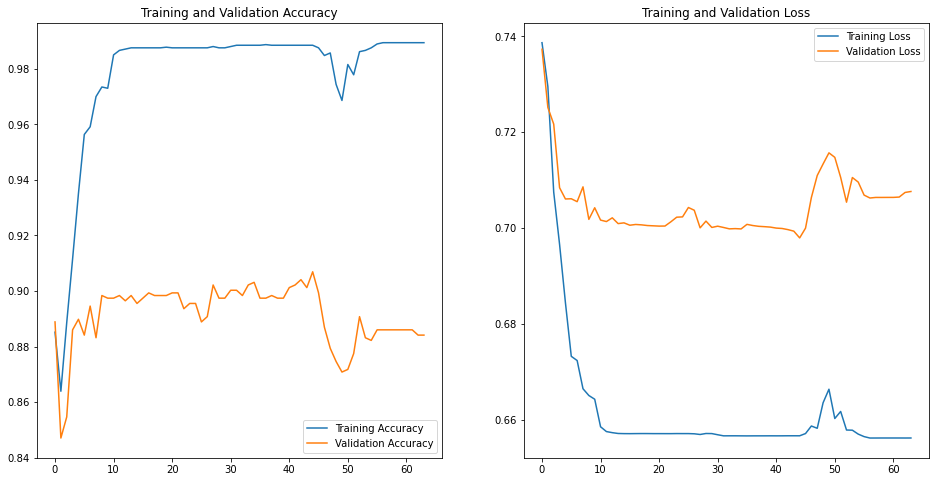

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

file_name = "graph.png"

plt.savefig(os.path.join(CHECKPOINT_DIR, file_name))

plt.show()

# Make some test predictions

In [29]:
TEST_DIR = "reduced_training_data/test"
TEST_CLASSES = ["707-320", "737-800", "777-200", "a330-200", "bae 146-300", "c-130", "eurofighter typhoon", "md-80", "spitfire"]

In [43]:
def plot_prediction(ax, prediction, actual, title):
    patches, texts, autotexts = ax.pie(prediction, labels=None, explode=[0.1] * 9, autopct='%1.1f%%', shadow=True)
    
    ax.set_title(title)
#     ax.axis('equal')
    ax.legend(patches, TEST_CLASSES, bbox_to_anchor=(1.75, 0.5), loc="center right")
    

In [31]:
# This function will plot images in the form of a grid with 1 row and 3 columns.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [32]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=1,
                                                              directory=TEST_DIR,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="grayscale",
                                                              class_mode='categorical')

Found 24 images belonging to 9 classes.


In [33]:
# plt.figure()
# test_images, _ = peek(test_data_gen)
# plotImages(test_images[:3])

In [34]:
predictions = model.predict(test_data_gen)
actual_classes = test_data_gen.classes

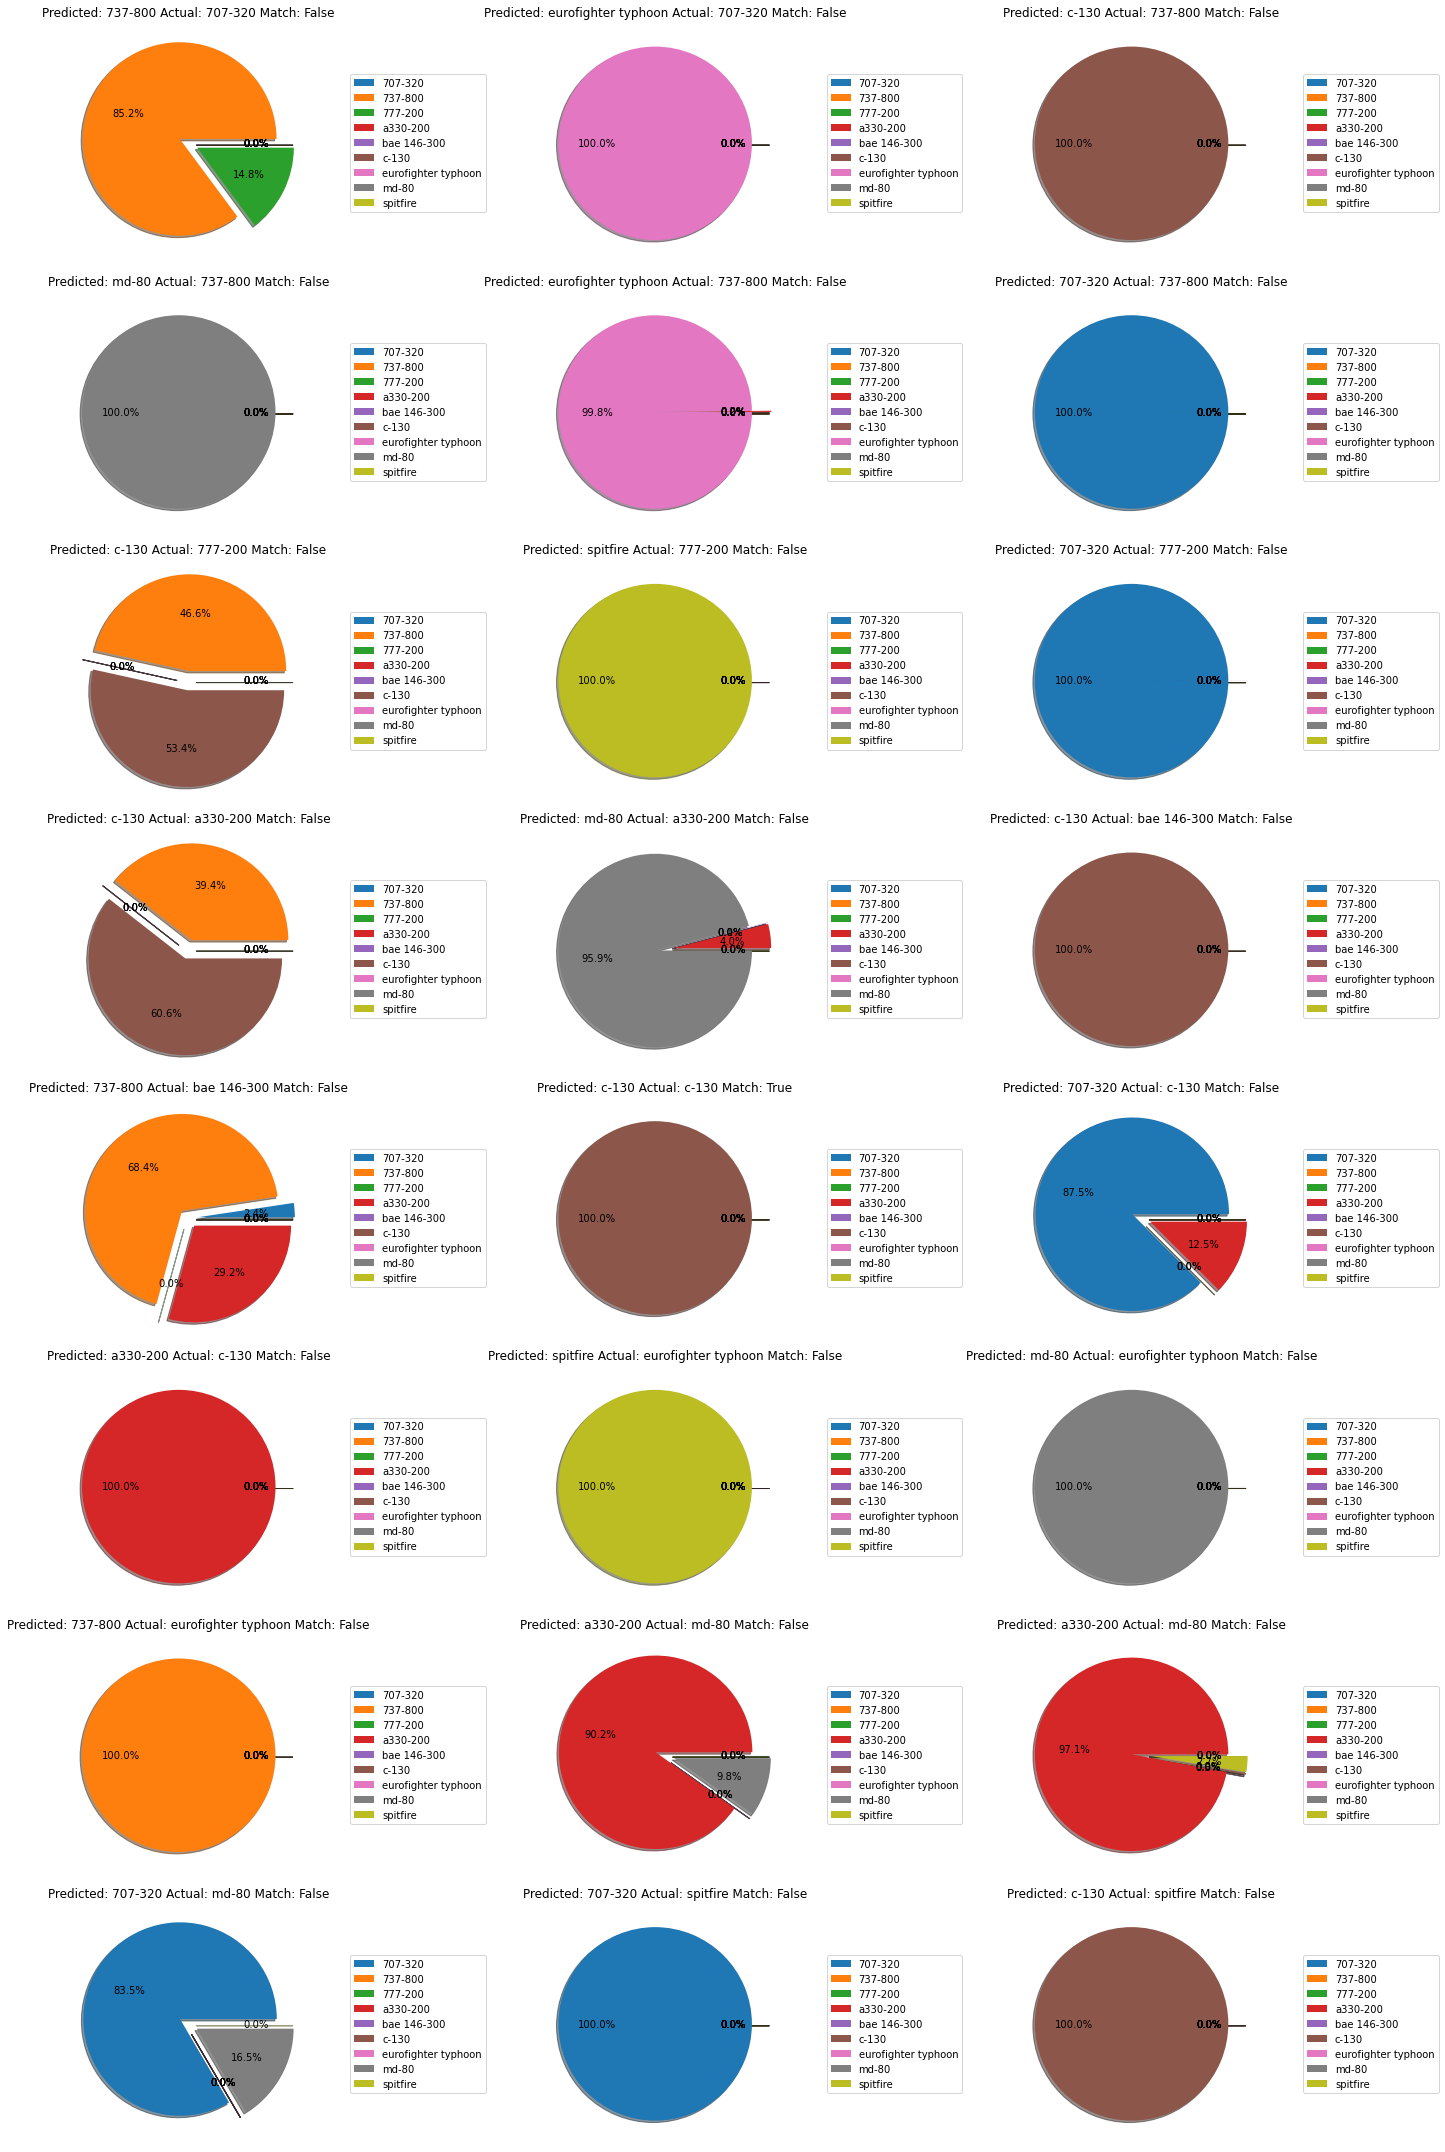

In [44]:
nrows = 3
ncol = 3

fig, ax = plt.subplots(math.ceil(len(predictions) / nrows), ncol, figsize=(20,30))

for index, predic in enumerate(predictions):
    predicted = np.argmax(predic)
    actual = actual_classes[index]
    title = "Predicted: {} Actual: {} Match: {}".format(TEST_CLASSES[predicted], TEST_CLASSES[actual], predicted==actual)
#     fig.figure(figsize=(6,24))
#     fig, ax = subplot(len(predictions), 1, index + 1)
    a = ax[int(index / nrows)][index % ncol]
    plot_prediction(a, predic, actual, title)

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "test_results.pdf"), dpi=300, bbox_inches='tight')
plt.show()
